In [1]:
using Serialization
using Printf
using CSV
using DataFrames
using ControlSystemsBase
using ControlTimingSafety
using LinearAlgebra: I
using Distributions: Pareto, Normal, cdf, quantile
using DelimitedFiles

using MATLABControlTest

push!(LOAD_PATH, "../src")
using Experiments
using Benchmarks
using ContinuousSims: nominal_trajectory
using Plots

In [2]:
function get_ref(t::Real)
	t_i = floor(Int64, t / 0.1) + 1
	@boundscheck 1 ≤ t_i ≤ 1000 || throw(ArgumentError("t=$t out of bound"))
	DATA[t_i, :r]
end

function get_period(q::Real)
    e_i = ceil(Int64, q * length(E_VALUES))
	@boundscheck 1 ≤ e_i ≤ length(E_VALUES) || throw(ArgumentError("t=$t out of 		bound"))
	E_VALUES[e_i]
end

get_period (generic function with 1 method)

In [4]:
BATCHSIZE = 1000
SYS = ss(tf([3, 1],[1, 0.6, 1]))
DATA = CSV.read("../MATLABControlTest.jl/output-jumping1000-1e3-O1.csv", DataFrame)
E_VALUES = sort(DATA[:, :t]) / 100_000 * 0.2

H = 1000 * 0.1
k = []
q_values = 0.01:0.01:0.99


0.01:0.01:0.99

In [3]:
for q in q_values
    period = get_period(q)
    ref_values = map(get_ref, 0:period:H)
    H_steps = length(ref_values)
    sysd = c2d(SYS, period)
    x0 = zeros(sysd.nx)
    t = generate_samples_mpc(sysd, x0, ref_values, q, BATCHSIZE, H=H_steps)
    a = t[990][2]
    push!(k, a)
end
k

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
     [1] *(A::Matrix{Float64}, B::Matrix{Float64})
       @ LinearAlgebra /snap/julia/98/share/julia/stdlib/v1.10/LinearAlgebra/src/matmul.jl:111
     [2] run_simulation(sysd::StateSpace{Discrete{Float64}, Float64}, x0::Vector{Float64}, refs::Vector{Float64}; input::BitVector)
       @ MATLABControlTest /mnt/c/My Project/pwcet-safety/MATLABControlTest.jl/src/MATLABControlTest.jl:76
     [3] run_simulation
       @ /mnt/c/My Project/pwcet-safety/MATLABControlTest.jl/src/MATLABControlTest.jl:48 [inlined]
     [4] macro expansion
       @ /mnt/c/My Project/pwcet-safety/src/Experiments.jl:80 [inlined]
     [5] (::Experiments.var"#29#threadsfor_fun#11"{Experiments.var"#29#threadsfor_fun#9#12"{StateSpace{Discrete{Float64}, Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{BitVector, Float64}}, SamplerPWCET, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Experiments ./threadingconstructs.jl:215
     [6] #29#threadsfor_fun
       @ ./threadingconstructs.jl:182 [inlined]
     [7] (::Base.Threads.var"#1#2"{Experiments.var"#29#threadsfor_fun#11"{Experiments.var"#29#threadsfor_fun#9#12"{StateSpace{Discrete{Float64}, Float64}, Vector{Float64}, Vector{Float64}, Vector{Tuple{BitVector, Float64}}, SamplerPWCET, UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:154

┌ Info: 0.88
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:4
┌ Info: 1536.15576171875
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:5


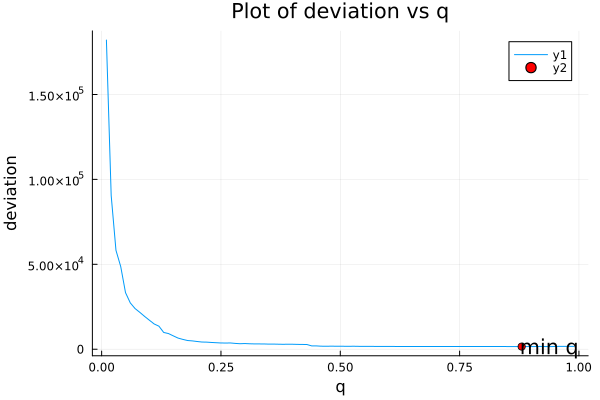

In [15]:
min_index = argmin(k)
min_q = q_values[min_index]
min_t = k[min_index]
@info min_q
@info min_t
plot(q_values, k, xlabel="q", ylabel="deviation", title="Plot of deviation vs q")
annotate!(min_q, min_t, text("min q", :left))
scatter!([min_q], [min_t], color=:red, marker=:circle)

┌ Info: 0.88
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:8
┌ Info: 0.11536
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:9
┌ Info: 1536.9093627929688
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:10


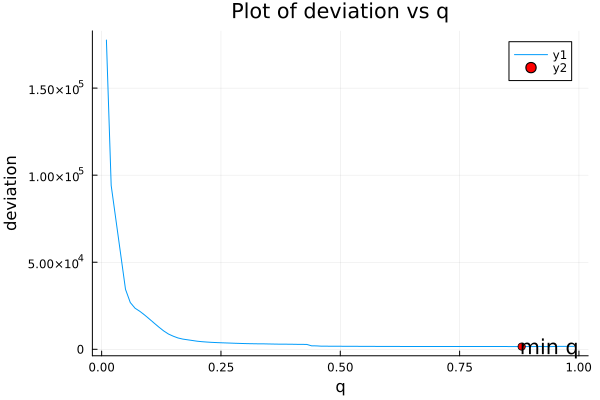

In [5]:
data = readdlm("../data-proxy/mpc-39927918.csv", ',')
a = data[:, 4]
min_index = argmin(a)
q = data[:, 1]
min_q = q[min_index]
period =  get_period(min_q)
min_t = a[min_index]
@info min_q
@info period
@info min_t
plot(q, a, xlabel="q", ylabel="deviation", title="Plot of deviation vs q")
annotate!(min_q, min_t, text("min q", :left))
scatter!([min_q], [min_t], color=:red, marker=:circle)